## In Class Random Forest Example 

A single decision tree is very deterministic. There is always an element of random chance in the real world, which you can miss if you're only using 1 model with a hierarchical order of the rules.

A way to avoid this potential over-fitting problem is to use many different decision trees that evaluate different subsets of variables on subsets of the data. This approach is called bootstrapping (bagging), and in the case of decision trees, it's implemented with an algorithm called Random Forest.

Random forests can be used for regression as well. 

In [1]:
#imports...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from lime import lime_tabular
from sklearn.inspection import permutation_importance

Below is a list of some the settings that you can customize when you run random forests. It's important to understand how you can customize the algorithm to make sure that your math works well for the data you're working with.

Some additional arguments are listed in the documentation, but are used less frequently.

In [54]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [100],  #<- Size of sample to draw each time.
            'min_samples_leaf': [5], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

### Splitting test and training sets

Let's run the random forest on our pregnancy data.
Subset a sample of 200 data points from our data, which we can use to test out the quality of our model.

In [2]:
#Load in new dataset
pregnancy = pd.read_csv("https://raw.githubusercontent.com/UVADS/DS-3001/main/data/pregnancy.csv")

#Let's get familiar with the data
pregnancy.info()
pregnancy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Pregnancy Test          2000 non-null   int64
 1   Birth Control           2000 non-null   int64
 2   Feminine Hygiene        2000 non-null   int64
 3   Folic Acid              2000 non-null   int64
 4   Prenatal Vitamins       2000 non-null   int64
 5   Prenatal Yoga           2000 non-null   int64
 6   Body Pillow             2000 non-null   int64
 7   Ginger Ale              2000 non-null   int64
 8   Sea Bands               2000 non-null   int64
 9   Stopped buying ciggies  2000 non-null   int64
 10  Cigarettes              2000 non-null   int64
 11  Smoking Cessation       2000 non-null   int64
 12  Stopped buying wine     2000 non-null   int64
 13  Wine                    2000 non-null   int64
 14  Maternity Clothes       2000 non-null   int64
 15  PREGNANT             

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Stopped buying ciggies,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes,PREGNANT
0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


In [4]:
#claculate the prevalence of the outcome, use the normalize 
# parameter to get the proportion
pregnancy['PREGNANT'].value_counts(normalize=True)


PREGNANT
0    0.72
1    0.28
Name: proportion, dtype: float64

In [3]:
#Split between features and target
X=pregnancy.drop(columns='PREGNANT')
y=pregnancy.PREGNANT

#Use train_test_split twice to get training, testing, and tuning dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify= y, random_state=21) 
#start with 10% of our dataset, could do 20% but random forest does require more training data
#because of the sampling so 90% might be a better approach with this small of a dataset
#remember, use random_state to create reproducible results

In [57]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

PREGNANT
0    1296
1     504
Name: count, dtype: int64
PREGNANT
0    144
1     56
Name: count, dtype: int64


In [26]:
#general rule to start with the max_features value is square root of the number of predictors
print('max_features = ' + str(np.sqrt(X.shape[1]))) #around 4

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

#Fit our data
pregnancy_RF= RFC.fit(X_train,y_train)



max_features = 3.872983346207417


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.0s finished


In [5]:
# Look at the output of the random forest.
print('OOB error rate: ' + str(1-pregnancy_RF.oob_score_))

OOB error rate: 0.18611111111111112


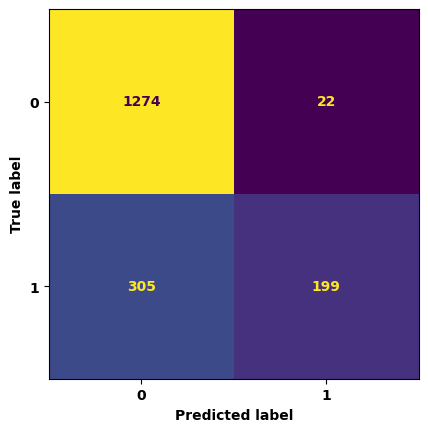

In [6]:
#Call up the confusion matrix and check the accuracy of the model.
ConfusionMatrixDisplay.from_estimator(pregnancy_RF,X_train,y_train, colorbar= False)

In [7]:
#Check the accuracy of the model.
pregnancy_RF.score(X_train,y_train) #(tn+tp)/(tn+tp+fn+fp) #0.82ish, not bad

0.8183333333333334

In [9]:
# View the percentage of trees that voted for 
# each data point to be in each class. 
# First column being not pregnant, second being pregnant
xx = pd.DataFrame(pregnancy_RF.oob_decision_function_)

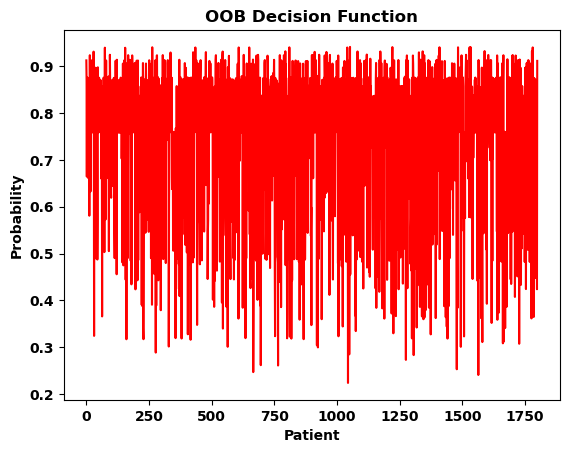

In [11]:
#create a line plot of xx
plt.plot(xx[0], 'r')
plt.title("OOB Decision Function")
plt.ylabel("Probability")
plt.xlabel("Shopper")
plt.show()

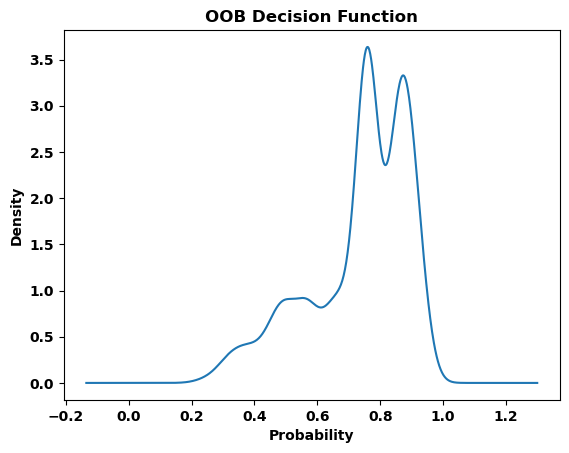

In [12]:
#create a densuty plot of xx
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()


In [15]:
#This contains a vector of predictions for each data point.
np.argmax(pregnancy_RF.oob_decision_function_,axis=1)

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [63]:
# The "importance" argument provides a table that includes the importance of each variable to the accuracy of the classification.
print(pd.DataFrame(pregnancy_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                        importance
Prenatal Vitamins         0.190139
Folic Acid                0.166912
Maternity Clothes         0.139048
Stopped buying wine       0.118826
Birth Control             0.076519
Feminine Hygiene          0.063600
Pregnancy Test            0.056940
Stopped buying ciggies    0.052287
Wine                      0.049131
Cigarettes                0.033905
Ginger Ale                0.031835
Smoking Cessation         0.017004
Sea Bands                 0.002991
Prenatal Yoga             0.000676
Body Pillow               0.000187


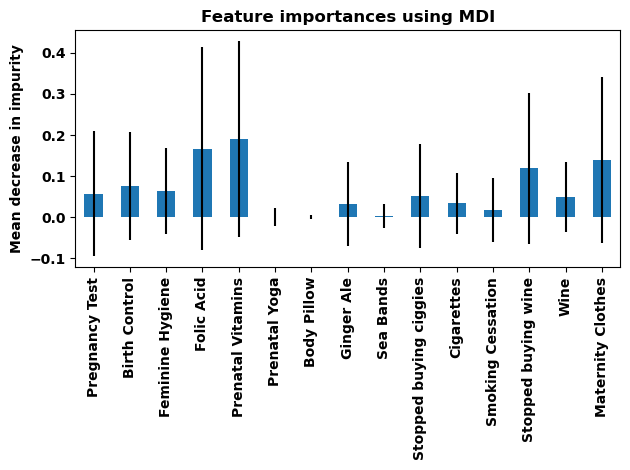

In [64]:
#Here we compute both the mean and standard
# deviation of accumulation of the impurity decrease within each tree.
importances = pregnancy_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in pregnancy_RF.estimators_], axis=0)

#graph it
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [13]:
 #Permutation feature importance does not have a bias toward 
 # high-cardinality features and can be computed on a test set. 
 # This will allow us to view the mean decrease in accuracy of each feature...

result = permutation_importance(
    pregnancy_RF, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2,scoring='precision'
)

#Combine results and column names to visualize 
forest_importances = pd.Series(result.importances_mean, index=X.columns)

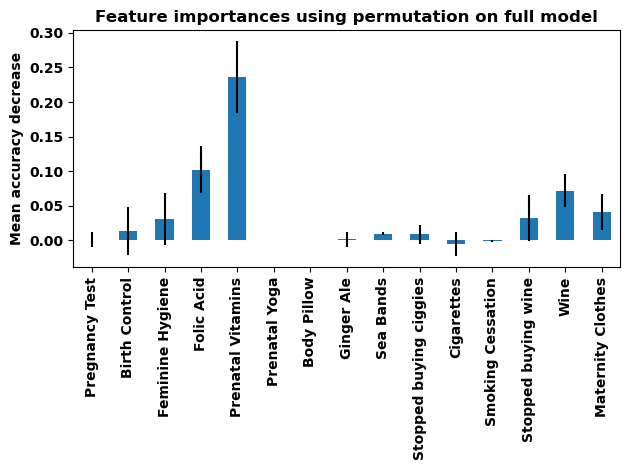

In [14]:
#The same features are detected as most important using both methods. 
# Although the relative importances vary
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [67]:
n_estimators_list = [100,200,300,400,500,600,700,800,900,1000]
forest_list = [RandomForestClassifier( n_estimators = n,
            max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p)
                    bootstrap= True, #<-Whether bootstrap samples are used when building trees
                    max_samples = 100,  #<- Size of sample to draw each time.
                    min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                    max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                    max_depth= None, #<-The maximum depth of the tree
                    oob_score=True,
                   warm_start=True,
                    random_state= 1984).fit(X_train, y_train) for n in n_estimators_list]

#Could also do every number from 0 to 1000 but takes a very long time
forest_list[:3]

[RandomForestClassifier(max_features=4, max_samples=100, min_samples_leaf=5,
                        oob_score=True, random_state=1984, warm_start=True),
 RandomForestClassifier(max_features=4, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=4, max_samples=100, min_samples_leaf=5,
                        n_estimators=300, oob_score=True, random_state=1984,
                        warm_start=True)]

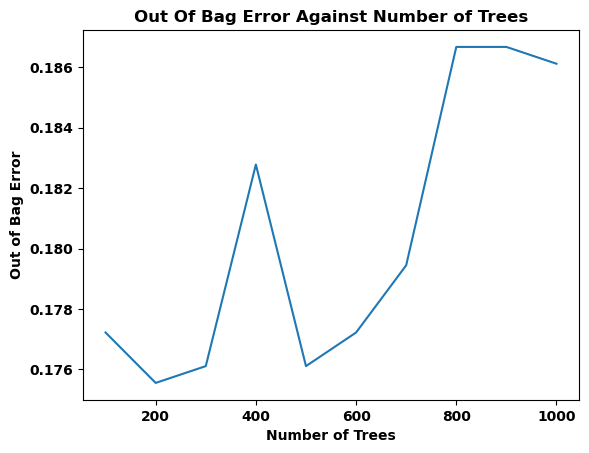

In [9]:
# Let's visualize the results of the random forest.
# Let's start by looking at how the error rate changes as we add more trees.

oob_errors = ([1-i.oob_score_ for i in forest_list])
plt.plot(n_estimators_list,oob_errors)
plt.title('Out Of Bag Error Against Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Out of Bag Error')
plt.show()

In [11]:
# Let's just say we want to do the best we can to label pregnant customers as pregnant
# later we can certainly adjust the threshold but want to tune to optimize the models ability 
# to identify the positive target class. 

pd.DataFrame(list(zip(n_estimators_list,oob_errors)), columns = ['number of trees','oob_error'])
# in the graph and dataframe above we see that a lower number of trees
# minimizes the oob error.

,number of trees,oob_error
0,100,0.177222
1,200,0.175556
2,300,0.176111
3,400,0.182778
4,500,0.176111
5,600,0.177222
6,700,0.179444
7,800,0.186667
8,900,0.186667
9,1000,0.186111


In [68]:
# Let's grab our random forest model we made with 200ish trees.

pregnancy_RF_eng = forest_list[1]
pregnancy_RF_eng #good

RandomForestClassifier(max_features=4, max_samples=100, min_samples_leaf=5,
                       n_estimators=200, oob_score=True, random_state=1984,
                       warm_start=True)

original model error: 0.18611111111111112
new model error: 0.17555555555555558


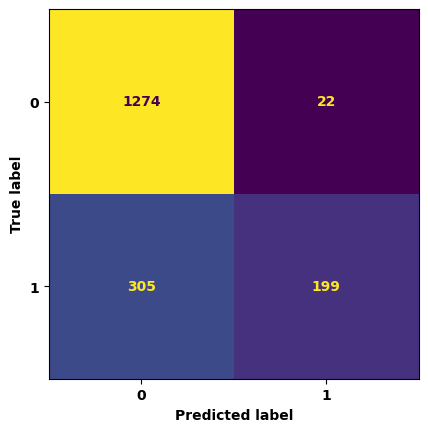

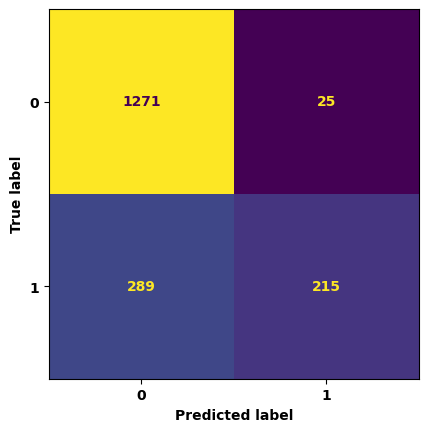

In [69]:
# Let's compare the confusion matrices between our 2 random forest models and the associated total error rates.
#original
print('original model error: ' +str(1-pregnancy_RF.oob_score_))
ConfusionMatrixDisplay.from_estimator(pregnancy_RF,X_train,y_train, colorbar= False)

#New
print('new model error: ' + str(1-pregnancy_RF_eng.oob_score_))
ConfusionMatrixDisplay.from_estimator(pregnancy_RF_eng,X_train,y_train, colorbar= False)

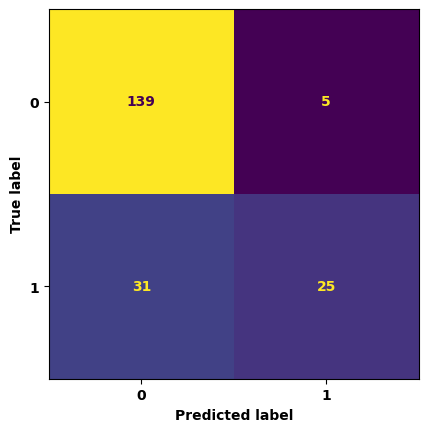

In [14]:
#Use the .predict function on our testing data with new model

pregnancy_predict = pregnancy_RF_eng.predict(X_test)

#create confusion matrix of test data predictions
ConfusionMatrixDisplay.from_predictions(y_test,pregnancy_predict, colorbar= False)

In [15]:
# How can we refine the model? First, let's make sure we have a good
# understanding for the structure of the model.
# Let's start by looking at the variables that are most important.
print(pd.DataFrame(pregnancy_RF_eng.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                        importance
Prenatal Vitamins         0.203716
Folic Acid                0.185772
Maternity Clothes         0.126232
Stopped buying wine       0.099968
Pregnancy Test            0.069500
Birth Control             0.065963
Feminine Hygiene          0.058630
Stopped buying ciggies    0.052096
Wine                      0.044967
Cigarettes                0.039095
Ginger Ale                0.033069
Smoking Cessation         0.015497
Sea Bands                 0.005060
Body Pillow               0.000434
Prenatal Yoga             0.000000


In [15]:
# There are a lot of parameters to set for the random forest.
# The package can help you identify the right number of variables to 
# randomly sample as candidates at each split (the max_features parameter)
#Let's explore for ourselves

max_features_list = [1,2,3,4,5,6,7,8,9,10]

forest_list2 = [RandomForestClassifier(n_estimators = 200,
            max_features= n, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                    bootstrap= True, #<-Whether bootstrap samples are used when building trees
                    max_samples = 100,  #<- Size of sample to draw each time.
                    min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                    max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                    max_depth= None, #<-The maximum depth of the tree
                    oob_score=True,
                   warm_start=True,
                    random_state= 1984).fit(X_train, y_train) for n in max_features_list]
forest_list2[:3]

[RandomForestClassifier(max_features=1, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=2, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=3, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True)]

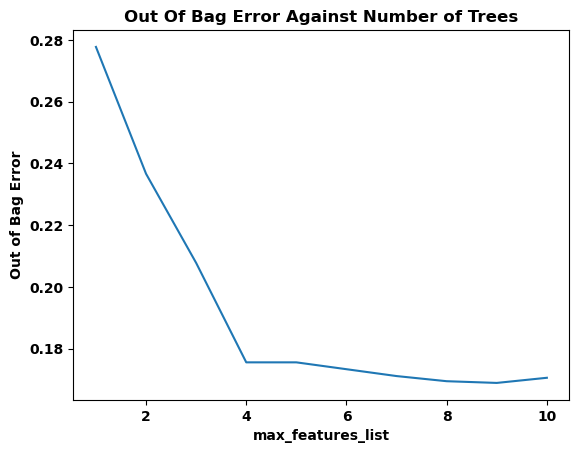

In [16]:
oob_errors1 = ([1-i.oob_score_ for i in forest_list2])
  #for error simply do 1-forest.oob_score_ 
plt.plot(max_features_list,oob_errors1)
plt.title('Out Of Bag Error Against Number of Trees')
plt.xlabel('max_features_list')
plt.ylabel('Out of Bag Error')
plt.show() # Looking at the OOB error graph, 4 seems to be the right 
# value to use in our random forest without overfitting

In [18]:
#assign correct model
pregnancy_RF_tune = forest_list2[3]
pregnancy_RF_tune #good


RandomForestClassifier(max_features=4, max_samples=100, min_samples_leaf=5,
                       n_estimators=200, oob_score=True, random_state=1984,
                       warm_start=True)

In [70]:
#fix the warning about feature names
#Create an explainer object
explainer = lime_tabular.LimeTabularExplainer(X_train.values,feature_names=X_train.columns,class_names=['Not Pregnant','Pregnant'],discretize_continuous=True)
#next
#Choose an observation to explain
observation = 85
#next
#Get the explanation for RF
exp = explainer.explain_instance(X_train.values[observation],pregnancy_RF_eng.predict_proba,num_features=15)
#next
#Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)


c:\Users\Brian Wright\miniconda3\envs\FMLF23\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


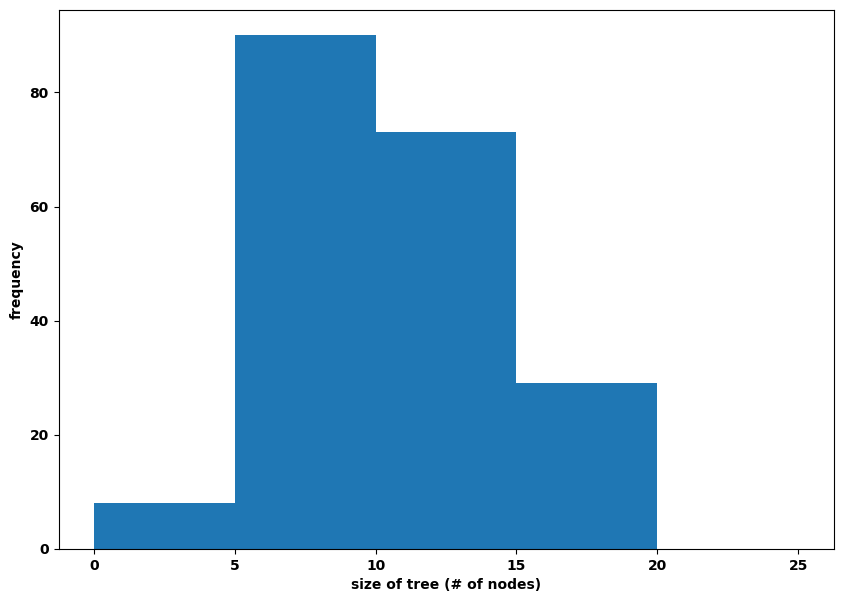

In [46]:
# If you want to look at the size of the trees in the random forest, 
# or how many nodes each tree has, you can access the estimators and use decisiontreeclassifier attribute functions.
#nodes = []
nodes = [tree.tree_.node_count for tree in pregnancy_RF_tune.estimators_]

#You can use these results to create a histogram for a visual presentation.
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(nodes, bins = [0, 5, 10, 15, 20, 25])
ax.set_ylabel('frequency')
ax.set_xlabel('size of tree (# of nodes)')
# Show plot
plt.show()

Text(0.5, 0, 'False Positive Rate')

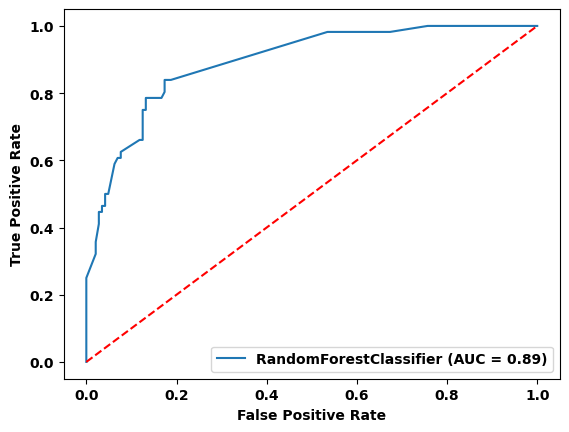

In [47]:
# It's OK if we classify as someone who is pregnant as not pregnant, 
# but we can have a big lawsuit on our hands if we falsely predict that someone is pregnant when in reality they are not. 
# Let's see how our relative true positives compare to the false positives.
# To do that we'll need to plot a ROC curve.

#Quickest and easiest method is to simply use the sklearn function RocCurveDisplay with our model and testing features + target
#This will give us an ROC plot with all reasonable thresholds given the probabilities of prediction
metrics.RocCurveDisplay.from_estimator(pregnancy_RF_tune, X_test,y_test)
#Set labels and midline...
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [51]:
#We can see where our optimal threshold is (closest point to top left corner), but let's get the exact value of it now 
#First get prediction probabilities of test data, only want positive class so extract second column
pred = pregnancy_RF_tune.predict_proba(X_test)[:,1]
#Use roc_curve function to get fpr, tpr and threshold values
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
pd.DataFrame(list(zip(thresholds, tpr, fpr)),columns = ['thresholds','tpr','fpr']).head(27) #good

,thresholds,tpr,fpr
0,1.716643,0.000000,0.000000
1,0.716643,0.017857,0.000000
2,0.645496,0.071429,0.000000
3,0.644179,0.107143,0.000000
4,0.568350,0.250000,0.000000
5,0.541035,0.321429,0.020833
6,0.532005,0.357143,0.020833
7,0.525521,0.410714,0.027778
8,0.510675,0.446429,0.027778
9,0.509385,0.446429,0.034722


In [49]:
#Locate index of best threshold, this is where true postive rate is highest and false positive rate is the lowest
ix = np.argmax(tpr-fpr) #np.argmax returns the index of maximum values along and axis
print('Best threshold: ' + str(thresholds[26]))

Best threshold: 0.2623885449534529


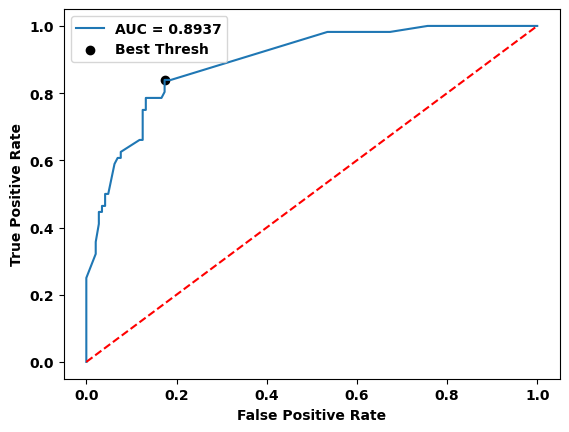

In [52]:
# plot the roc curve for the model with best threshold highlighted
#Get auc score first to add to plot
auc = metrics.roc_auc_score(y_test, pred)
#plot fpr and tpr
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % auc) 
#add in best threshold highlight
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Thresh')
# axis labels
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

You can now tune for forecast for each point, by setting a different threshold
for how many trees need to vote for a point as "pregnant" in order for you to
make that class assignment. This is where your domain knowledge becomes critical,
this is a management decision. How much risk can the business tolerate?
The closer the ROC curve is to a right angle, the higher the AUC, the more accurate
the model under different thresholds. The reason data scientists build many 
different classification models and compare the AUC values, is that they want to 
make sure that they have built the best possible model using several approaches.